# C rate dependence
Peter Attia, April 18 2020

In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

import scipy.stats
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

from scipy.constants import R
from scipy.constants import physical_constants
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.legend_handler import HandlerBase

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

figpath = Path.cwd().parent / 'figures'

## Load data

Metadata:

In [3]:
metadata = pd.read_csv('masses.csv')
metadata

,File name,Mass (mg),C rate
0,cellA_Cover100_split_CA1,0.977,0.010000
1,cellA_Cover100_CC4,0.548,0.010000
2,cellC_Cover30_split_CC5,0.914,0.033333
3,cellD_Cover30_CC6,0.845,0.033333
4,cellA_Cover10_CC7,0.776,0.100000
5,cellE_Cover3_split_CC8,0.809,0.333333
6,cellC_Cover3_CF6,0.583,0.333333
7,cellG_1C_split_CD3,0.468,1.000000
8,cellM_1C_CD5,0.743,1.000000
9,cellF_3C_split_CF6,1.011,3.000000


## Constant current data
Raw data:

In [4]:
files_constcurr = list((Path.cwd() / 'constant current data').glob('*.txt'))
files_constcurr

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellA_Cover100_CC4.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellJ_3C_CD8.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellM_1C_CD5.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellC_Cover3_CF6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellD_Cover30_CC6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellC_10C_CF3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellA_Cover10_CC7.txt')]

Parse and process:

In [5]:
all_data_constcurr = {}

for file in files_constcurr:
    
    sub_dict = {}
    
    # C rate parsing
    C_rate = int(re.findall(r'\d+', file.name.split('_')[1])[0])
    C_rate_string = file.name.split('_')[1].replace('over', '/')
    
    if 'Cover' in file.name:
        C_rate = 1 / C_rate
    
    # Logging
    print(f'{file.stem}: {C_rate}, {C_rate_string}')
    
    # Load data
    data = np.loadtxt(file, skiprows=1)
    
    # Get mass
    mass = metadata[metadata['File name'] == file.stem]['Mass (mg)'].iloc[0] / 1000 # mg -> g
    
    # Normalize capacity by mass
    data[:, 2] = data[:, 2] / mass # mAh -> mAh/g
    
    # Index different cycle numbers
    first_lith_idx = np.where(data[:, 0] == 1)[0][0]
    second_cycle_idx = np.where(data[:, 0] == 2)[0][0]
    second_lith_idx = first_lith_idx + np.where(data[first_lith_idx:second_cycle_idx, 1] == np.max(data[first_lith_idx:second_cycle_idx, 1]))[0][0]
    try:
        third_cycle_idx = np.where(data[:, 0] == 3)[0][0]
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:third_cycle_idx, 1] == np.max(data[second_cycle_idx:third_cycle_idx, 1]))[0][0]
    except IndexError: # 10C data has only 2 cycles
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:, 1] == np.max(data[second_cycle_idx:, 1]))[0][0]
    
    # Extract (de)lith steps
    first_lith_data = data[:first_lith_idx]
    first_delith_data = data[first_lith_idx:second_lith_idx]
    second_lith_data = data[second_lith_idx:second_cycle_idx]
    second_delith_data = data[second_cycle_idx:third_lith_idx]
    
    # Get first-lithiation capacity above/below 0.5V
    idx_0pt5V = np.where(data[:, 1] < 0.5)[0][0]
    Qlith_cyc1_above0pt5 = np.max(first_lith_data[:idx_0pt5V])
    Qlith_cyc1_below0pt5 = np.max(first_lith_data) - Qlith_cyc1_above0pt5
    
    # Get first-lithiation time
    I = 200 * C_rate # 1C = 200 mAh/g
    tlith_cyc1 = np.max(first_lith_data) / I # t = Q/I; mAh/g / mA/g -> h
    
    # Get capacities for CE
    Qlith_cyc2 = np.max(second_lith_data)
    Qdelith_cyc2 = np.max(second_delith_data)
    CE_cyc2 = 100 * Qdelith_cyc2 / Qlith_cyc2
    
    # Create dictionary    
    sub_dict['First lith data'] = first_lith_data
    sub_dict['First delith data'] = first_delith_data
    sub_dict['Second lith data'] = second_lith_data
    sub_dict['Second delith data'] = second_delith_data
    
    sub_dict['C rate'] = C_rate
    sub_dict['C rate string'] = C_rate_string
    sub_dict['1st lith capacity above 0.5V'] = Qlith_cyc1_above0pt5
    sub_dict['1st lith capacity below 0.5V'] = Qlith_cyc1_below0pt5
    sub_dict['1st lith time'] = tlith_cyc1
    sub_dict['2nd cycle CE'] = CE_cyc2
    
    if C_rate_string != '10C':
        
        Q = first_lith_data[:,2]
        V = first_lith_data[:,1]
        
        # Filter and get dQ/dV
        Q_filt = savgol_filter(Q, 101, 1)
        V_filt = savgol_filter(V, 101, 1)
        dQdV = np.gradient(Q_filt, V_filt)

        # Get V_peak
        idx1pt2 = np.where(V_filt < 1.2)[0][0]
        idx0pt5 = np.where(V_filt < 0.5)[0][0]
        peak_idx, _ = find_peaks(-dQdV[idx1pt2:idx0pt5], distance=1e7)
        peak_idx = idx1pt2 + peak_idx[0]
        
        V_peak = V_filt[peak_idx]
        dQdV_peak = dQdV[peak_idx]
        
        sub_dict['V_filt'] = V_filt
        sub_dict['dQdV'] = dQdV
        sub_dict['V_peak'] = V_peak
        sub_dict['dQdV_peak'] = dQdV_peak
        
    # Append to main dictionary
    all_data_constcurr[file.stem] = sub_dict

cellA_Cover100_CC4: 0.01, C/100
cellJ_3C_CD8: 3, 3C
cellM_1C_CD5: 1, 1C
cellC_Cover3_CF6: 0.3333333333333333, C/3
cellD_Cover30_CC6: 0.03333333333333333, C/30
cellC_10C_CF3: 10, 10C
cellA_Cover10_CC7: 0.1, C/10


Sort:

In [6]:
all_data_constcurr = {k: v for k, v in sorted(all_data_constcurr.items(), key=lambda item: item[1]['C rate'])}

Min/max V_peak:

In [7]:
for k, (key, value) in enumerate(all_data_constcurr.items()):
    if '10C' not in key:
        print(f"{key}: {value['V_peak']}")

cellA_Cover100_CC4: 1.0406326495049505
cellD_Cover30_CC6: 0.9779112938613862
cellA_Cover10_CC7: 0.9191045367326736
cellC_Cover3_CF6: 0.8239095846534654
cellM_1C_CD5: 0.7610608448514855
cellJ_3C_CD8: 0.6743408152475245


## Multistep data
Raw data:

In [8]:
files_multistep = list((Path.cwd() / 'multistep current data').glob('*.txt'))
files_multistep

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellC_Cover30_split_CC5.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellA_Cover100_split_CA1.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellK_10C_split_CF1.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellF_3C_split_CF6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellE_Cover3_split_CC8.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellG_1C_split_CD3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellA_Cover10_CC7.txt')]

Parse and process:

cellC_Cover30_split_CC5: 0.03333333333333333, C/30(0.5V)-C/10
cellA_Cover100_split_CA1: 0.01, C/100(0.5V)-C/10
cellK_10C_split_CF1: 10, 10C(0.5V)-C/10
cellF_3C_split_CF6: 3, 3C(0.5V)-C/10
cellE_Cover3_split_CC8: 0.3333333333333333, C/3(0.5V)-C/10
cellG_1C_split_CD3: 1, 1C(0.5V)-C/10
cellA_Cover10_CC7: 0.1, C/10


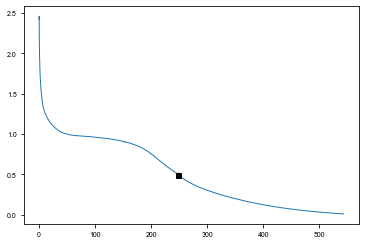

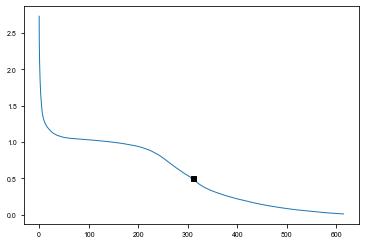

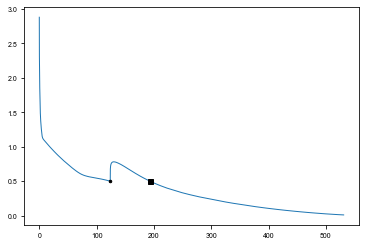

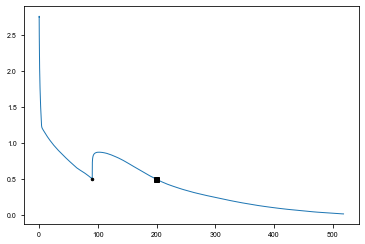

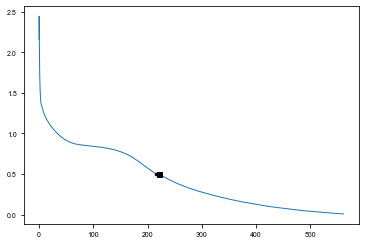

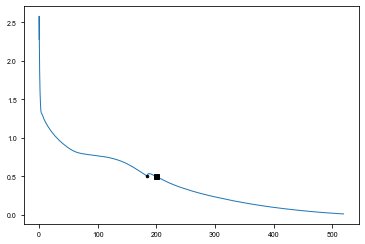

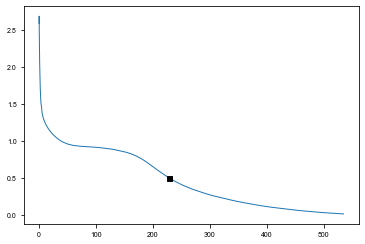

In [9]:
all_data_multistep = {}

for file in files_multistep:
    
    sub_dict = {}
    
    # C rate parsing
    C_rate = int(re.findall(r'\d+', file.name.split('_')[1])[0])
    C_rate_string = file.name.split('_')[1].replace('over', '/') + '(0.5V)-C/10'
    if C_rate_string == 'C/10(0.5V)-C/10':
        C_rate_string = 'C/10'
    
    if 'Cover' in file.name:
        C_rate = 1 / C_rate
    
    # Logging
    print(f'{file.stem}: {C_rate}, {C_rate_string}')
    
    # Load data
    data = np.loadtxt(file, skiprows=1)
    
    # Get mass
    mass = metadata[metadata['File name'] == file.stem]['Mass (mg)'].iloc[0] / 1000 # mg -> g
    
    # Normalize capacity by mass
    data[:, 2] = data[:, 2] / mass # mAh -> mAh/g
    
    # Index different cycle numbers
    first_lith_idx = np.where(data[:, 0] == 1)[0][0]
    second_cycle_idx = np.where(data[:, 0] == 2)[0][0]
    third_cycle_idx = np.where(data[:, 0] == 3)[0][0]
    second_lith_idx = first_lith_idx + np.where(data[first_lith_idx:second_cycle_idx, 1] == np.max(data[first_lith_idx:second_cycle_idx, 1]))[0][0]
    third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:third_cycle_idx, 1] == np.max(data[second_cycle_idx:third_cycle_idx, 1]))[0][0]
    
    # Extract (de)lith steps
    first_lith_data = data[:first_lith_idx]
    first_delith_data = data[first_lith_idx:second_lith_idx]
    second_lith_data = data[second_lith_idx:second_cycle_idx]
    second_delith_data = data[second_cycle_idx:third_lith_idx]
    
    # Get first-lithiation capacity above/below 0.5V
    # I exclude the capacity above 0.5 V *after* the overpotential relaxation
    idx_0pt5V_above = np.where(data[:, 1] < 0.501)[0][0]
    idx_0pt5V_below = np.where(data[:, 1] < 0.499)[0][0]
    Qlith_cyc1_above0pt5 = np.max(first_lith_data[:idx_0pt5V_above])
    Qlith_intermediate = first_lith_data[idx_0pt5V_below, 2] - first_lith_data[idx_0pt5V_above, 2]
    Qlith_cyc1_below0pt5 = np.max(first_lith_data) - Qlith_cyc1_above0pt5 - Qlith_intermediate
    
    # Get first-lithiation time. a = before split, b = after split
    Ia = 200 * C_rate # 1C = 200 mAh/g
    Ib = 200 * 0.1 # 1C = 200 mAh/g
    tlith_cyc1a = Qlith_cyc1_above0pt5 / Ia # t = Q/I; mAh/g / mA/g -> h
    tlith_cyc1b = (Qlith_intermediate + Qlith_cyc1_below0pt5) / Ib # t = Q/I; mAh/g / mA/g -> h
    
    # Get capacities for CE
    Qlith_cyc2 = np.max(second_lith_data)
    Qdelith_cyc2 = np.max(second_delith_data)
    CE_cyc2 = 100 * Qdelith_cyc2 / Qlith_cyc2
    
    # Create dictionary
    sub_dict['First lith data'] = first_lith_data
    sub_dict['First delith data'] = first_delith_data
    sub_dict['Second lith data'] = second_lith_data
    sub_dict['Second delith data'] = second_delith_data
    
    sub_dict['C rate'] = C_rate
    sub_dict['C rate string'] = C_rate_string
    sub_dict['1st lith capacity above 0.5V'] = Qlith_cyc1_above0pt5
    sub_dict['1st lith capacity below 0.5V'] = Qlith_cyc1_below0pt5
    sub_dict['1st lith time'] = tlith_cyc1a + tlith_cyc1b
    sub_dict['2nd cycle CE'] = CE_cyc2
    
    if C_rate_string != '10C(0.5V)-C/10':
        
        Q = first_lith_data[:idx_0pt5V_above,2]
        V = first_lith_data[:idx_0pt5V_above,1]
        
        # Filter and get dQ/dV
        Q_filt = savgol_filter(Q, 101, 1)
        V_filt = savgol_filter(V, 101, 1)
        dQdV = np.gradient(Q_filt, V_filt)

        # Get V_peak
        idx1pt2 = np.where(V_filt < 1.2)[0][0]
        peak_idx, _ = find_peaks(-dQdV[idx1pt2:], distance=1e7)
        peak_idx = idx1pt2 + peak_idx[0]
        
        V_peak = V_filt[peak_idx]
        dQdV_peak = dQdV[peak_idx]
        
        sub_dict['V_filt'] = V_filt
        sub_dict['dQdV'] = dQdV
        sub_dict['V_peak'] = V_peak
        sub_dict['dQdV_peak'] = dQdV_peak
    
    # Append to main dictionary
    all_data_multistep[file.stem] = sub_dict
    
    # Plot as sanity check
    plt.figure()
    plt.plot(first_lith_data[:, 2], first_lith_data[:, 1])
    plt.plot(first_lith_data[idx_0pt5V_above, 2], first_lith_data[idx_0pt5V_above, 1], '.k')
    plt.plot(first_lith_data[idx_0pt5V_below, 2], first_lith_data[idx_0pt5V_below, 1], 'sk')

Sort:

In [10]:
all_data_multistep = {k: v for k, v in sorted(all_data_multistep.items(), key=lambda item: item[1]['C rate'])}

## 10C supplementary figure
We can see the peak in the second cycle of 10C

In [11]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           color=orig_handle[0])
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[1])
        return [l1, l2]

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


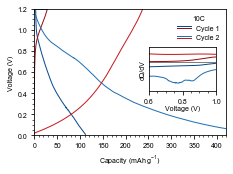

In [12]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height), nrows=1, ncols=1)

colors_blue = cm.Blues(np.linspace(0.9, 0.3, 5))[:,0:3]
colors_red  = cm.Reds( np.linspace(0.9, 0.3, 5))[:,0:3]

ax.set_xlabel('Capacity (mAh g$^{-1}$)')
ax.set_ylabel('Voltage (V)')
ax.set_xlim([0, 420])
ax.set_ylim([0, 1.2])
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax_inset0 = inset_axes(ax, width='100%', height='100%',
                       bbox_to_anchor=(0.58, 0.375, 0.35, 0.35),
                       bbox_transform=ax.transAxes,
                       loc='upper left')
ax_inset0.set_xlabel('Voltage (V)', labelpad=-0.1)
ax_inset0.set_ylabel('dQ/dV')
ax_inset0.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset0.set_xlim([0.6, 1.0])
ax_inset0.set_ylim([-500, 250])
ax_inset0.get_yaxis().set_ticks([])
ax_inset0.axhline(0, color='tab:gray')


lith1 = all_data_constcurr['cellC_10C_CF3']['First lith data']
delith1 = all_data_constcurr['cellC_10C_CF3']['First delith data']
lith2 = all_data_constcurr['cellC_10C_CF3']['Second lith data']
delith2 = all_data_constcurr['cellC_10C_CF3']['Second delith data']

ax.plot(lith1[:,2], lith1[:,1], color=colors_blue[0])
ax.plot(delith1[:,2], delith1[:,1], color=colors_red[0])
ax.plot(lith2[:,2], lith2[:,1], color=colors_blue[1])
ax.plot(delith2[:,2], delith2[:,1], color=colors_red[1])

# Filter and get dQ/dV
filter_size = 101
Q_filt_lith1 = savgol_filter(lith1[:,2], filter_size, 1)
V_filt_lith1 = savgol_filter(lith1[:,1], filter_size, 1)
dQdV_lith1 = np.gradient(Q_filt_lith1, V_filt_lith1)

Q_filt_delith1 = savgol_filter(delith1[:,2], filter_size, 1)
V_filt_delith1 = savgol_filter(delith1[:,1], filter_size, 1)
dQdV_delith1 = np.gradient(Q_filt_delith1, V_filt_delith1)

Q_filt_lith2 = savgol_filter(lith2[:,2], filter_size, 1)
V_filt_lith2 = savgol_filter(lith2[:,1], filter_size, 1)
dQdV_lith2 = np.gradient(Q_filt_lith2, V_filt_lith2)

Q_filt_delith2 = savgol_filter(delith2[:,2], filter_size, 1)
V_filt_delith2 = savgol_filter(delith2[:,1], filter_size, 1)
dQdV_delith2 = np.gradient(Q_filt_delith2, V_filt_delith2)

ax_inset0.plot(V_filt_lith1, dQdV_lith1, color=colors_blue[0])
ax_inset0.plot(V_filt_delith1, dQdV_delith1, color=colors_red[0])
ax_inset0.plot(V_filt_lith2, dQdV_lith2, color=colors_blue[1])
ax_inset0.plot(V_filt_delith2, dQdV_delith2, color=colors_red[1])


ax.legend([(colors_blue[0], colors_red[0]),
            (colors_blue[1], colors_red[1])],
            ['Cycle 1', 'Cycle 2'],
            handler_map={tuple: AnyObjectHandler()},
            loc='upper right',
            title='10C')


plt.tight_layout()
plt.savefig(figpath / 'C_rate_10C.eps', bbox_inches='tight', format='eps')

## Create plot

Create colors:

In [13]:
colors_constcurr  = cm.Blues( np.linspace(0.4, 0.9, len(all_data_constcurr.items())))[:,0:3]
colors_multistep  = cm.Purples( np.linspace(0.4, 0.9, len(all_data_multistep.items())))[:,0:3]

In [14]:
def make_legend(ax, loc):
    ax.plot(-1, 1, 'ok', label='Constant current')
    ax.plot(-1, 1, 'sk', label='Multistep current')
    ax.legend(loc=loc)

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


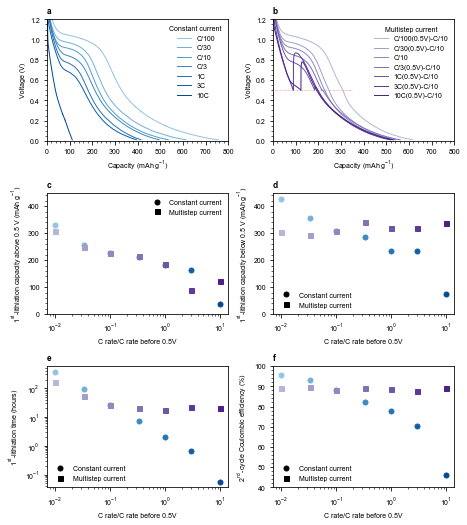

In [15]:
fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*3), nrows=3, ncols=2)
ax = ax.ravel()

# Set main axes labels
for k, a in enumerate(ax):
    a.set_title(chr(97+k), loc='left', weight='bold')
    if k == 0 or k == 1:
        a.set_xlabel('Capacity (mAh g$^{-1}$)')
    else:
        a.set_xlabel('C rate/C rate before 0.5V')
        make_legend(a, 'lower left' if k != 2 else 'best')

ax[0].set_ylabel('Voltage (V)')
ax[1].set_ylabel('Voltage (V)')
ax[2].set_ylabel(r'1$^{\rm st}$-lithiation capacity above 0.5 V (mAh g$^{-1}$)')
ax[3].set_ylabel(r'1$^{\rm st}$-lithiation capacity below 0.5 V (mAh g$^{-1}$)')
ax[4].set_ylabel(r'1$^{\rm st}$-lithiation time (hours)')
ax[5].set_ylabel(r'2$^{\rm nd}$-cycle Coulombic efficiency (%)')

ax[0].set_xlim([0, 800])
ax[1].set_xlim([0, 800])
ax[0].set_ylim([0, 1.2])
ax[1].set_ylim([0, 1.2])
ax[2].set_ylim([0, 450])
ax[3].set_ylim([0, 450])
ax[5].set_ylim([40, 100])

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[3].yaxis.set_minor_locator(AutoMinorLocator())
ax[5].yaxis.set_minor_locator(AutoMinorLocator())

ax[1].plot([0, 350], [0.5, 0.5], color='tab:red', lw=0.5, ls=':')

## Constant current cycling

for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    # Extract values
    first_lith_data = value['First lith data']
    C_rate = value['C rate']
    C_rate_string = value['C rate string']
    CE_cyc2 = value['2nd cycle CE']
    tlith_cyc1 = value['1st lith time']
    Qlith_cyc1_above0pt5 = value['1st lith capacity above 0.5V']
    Qlith_cyc1_below0pt5 = value['1st lith capacity below 0.5V']
    
    Q = first_lith_data[:, 2]
    V = first_lith_data[:, 1]
    
    ax[0].plot(Q, V, color=colors_constcurr[k], label=C_rate_string)
    ax[2].semilogx(C_rate, Qlith_cyc1_above0pt5, 'o', color=colors_constcurr[k])
    ax[3].semilogx(C_rate, Qlith_cyc1_below0pt5, 'o', color=colors_constcurr[k])
    ax[4].loglog(C_rate, tlith_cyc1, 'o', color=colors_constcurr[k])
    ax[5].semilogx(C_rate, CE_cyc2, 'o', color=colors_constcurr[k])
    
ax[0].legend(loc='upper right', title='Constant current')


## Multistep cycling

for k, (key, value) in enumerate(all_data_multistep.items()):
    
    # Extract values
    first_lith_data = value['First lith data']
    C_rate = value['C rate']
    C_rate_string = value['C rate string']
    CE_cyc2 = value['2nd cycle CE']
    tlith_cyc1 = value['1st lith time']
    Qlith_cyc1_above0pt5 = value['1st lith capacity above 0.5V']
    Qlith_cyc1_below0pt5 = value['1st lith capacity below 0.5V']
    
    Q = first_lith_data[:, 2]
    V = first_lith_data[:, 1]
    
    ax[1].plot(Q, V, color=colors_multistep[k], label=C_rate_string)
    ax[2].semilogx(C_rate, Qlith_cyc1_above0pt5, 's', color=colors_multistep[k])
    ax[3].semilogx(C_rate, Qlith_cyc1_below0pt5, 's', color=colors_multistep[k])
    ax[4].loglog(C_rate, tlith_cyc1, 's', color=colors_multistep[k])
    ax[5].semilogx(C_rate, CE_cyc2, 's', color=colors_multistep[k])
    
ax[1].legend(loc='upper right', title='Multistep current')

plt.tight_layout()
plt.savefig(figpath / 'C_rate.eps', bbox_inches='tight', format='eps')

## Correlation analysis

In [16]:
def make_legend(ax, loc):
    ax.plot(-100, 1, 'ok', label='Constant current')
    ax.plot(-100, 1, 'sk', label='Multistep current')
    ax.legend(loc=loc)

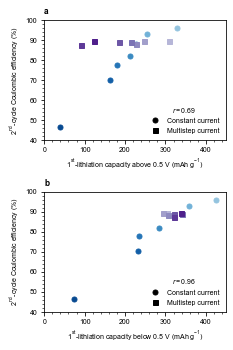

In [17]:
Qlith_cyc1_above0pt5_list = []
Qlith_cyc1_below0pt5_list = []
CE_cyc2_list = []

fig, ax = plt.subplots(figsize=(fig_width, fig_height*2), nrows=2, ncols=1)
ax = ax.ravel()

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

ax[0].set_xlabel(r'1$^{\rm st}$-lithiation capacity above 0.5 V (mAh g$^{-1}$)')
ax[1].set_xlabel(r'1$^{\rm st}$-lithiation capacity below 0.5 V (mAh g$^{-1}$)')
ax[0].set_ylabel(r'2$^{\rm nd}$-cycle Coulombic efficiency (%)')
ax[1].set_ylabel(r'2$^{\rm nd}$-cycle Coulombic efficiency (%)')

ax[0].set_xlim([0, 450])
ax[1].set_xlim([0, 450])
ax[0].set_ylim([40, 100])
ax[1].set_ylim([40, 100])

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

make_legend(ax[0], 'lower right')
make_legend(ax[1], 'lower right')

for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    Qlith_cyc1_above0pt5_list.append(value['1st lith capacity above 0.5V'])
    Qlith_cyc1_below0pt5_list.append(value['1st lith capacity below 0.5V'])
    CE_cyc2_list.append(value['2nd cycle CE'])
    
    ax[0].plot(Qlith_cyc1_above0pt5_list[-1], CE_cyc2_list[-1], 'o', color=colors_constcurr[k])
    ax[1].plot(Qlith_cyc1_below0pt5_list[-1], CE_cyc2_list[-1], 'o', color=colors_constcurr[k])

for k, (key, value) in enumerate(all_data_multistep.items()):
    
    Qlith_cyc1_above0pt5_list.append(value['1st lith capacity above 0.5V'])
    Qlith_cyc1_below0pt5_list.append(value['1st lith capacity below 0.5V'])
    CE_cyc2_list.append(value['2nd cycle CE'])
    
    ax[0].plot(Qlith_cyc1_above0pt5_list[-1], CE_cyc2_list[-1], 's', color=colors_multistep[k])
    ax[1].plot(Qlith_cyc1_below0pt5_list[-1], CE_cyc2_list[-1], 's', color=colors_multistep[k])
    
# Get correlations
r_above = pearsonr(Qlith_cyc1_above0pt5_list, CE_cyc2_list)[0]
r_below = pearsonr(Qlith_cyc1_below0pt5_list, CE_cyc2_list)[0]
    
ax[0].legend(title='$r=%.2f$' % r_above)
ax[1].legend(title='$r=%.2f$' % r_below, loc='lower right')

plt.tight_layout()
plt.savefig(figpath / 'C_rate_CE_corrlations.eps', bbox_inches='tight', format='eps')

## dQ/dV

Physical constants

In [18]:
z = 2
F = physical_constants['Faraday constant'][0] # C mol^-1
T = 273.15 + 30 # deg C
f = z * F / (R * T) # V^-1

Butler-Volmer and Tafel equations. The log versions are better for fitting

In [19]:
def Butler_Volmer(x, i0, alpha, E0):
    return i0 * ( np.exp(alpha*f*(E0 - x)) - np.exp(-(1-alpha)*f*(E0 - x)) )

In [20]:
def Tafel(x, i0, alpha, E0):
    return i0 * np.exp(alpha*f*(E0 - x))

In [21]:
def Butler_Volmer_log(x, i0, alpha, E0):
    return np.log(   i0 * ( np.exp(alpha*f*(E0 - x)) - np.exp(-(1-alpha)*f*(E0 - x)) )    )

In [22]:
def Tafel_log(x, i0, alpha, E0):
    return np.log(  i0 * np.exp(alpha*f*(E0 - x))  )

Plot:

In [23]:
def make_legend(ax, loc):
    ax.plot(-1, 1, 'ok', label='Constant current')
    ax.plot(-1, 1, 'sk', label='Multistep current')
    ax.legend(loc=loc)

0.011484233348669541 0.1951129276743987 1.0550387532781795


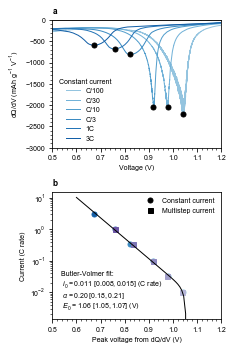

In [24]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height*2), nrows=2, ncols=1)
ax = ax.ravel()

# Set main axes labels
ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

ax[0].set_xlabel('Voltage (V)')
ax[0].set_ylabel('dQ/dV (mAh g$^{-1}$ V$^{-1}$)')
ax[1].set_xlabel('Peak voltage from dQ/dV (V)')
ax[1].set_ylabel('Current (C rate)')

ax[0].set_xlim([0.5, 1.2])
ax[1].set_xlim([0.5, 1.2])
ax[0].set_ylim([-3000, 0])
#ax[1].set_ylim([0, 1.2])

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].axhline(0, color='tab:gray')

make_legend(ax[1], 'upper right' if k != 2 else 'best')

## dQ/dV

colors  = cm.Blues( np.linspace(0.4, 0.9, len(all_data_constcurr.items())))[:,0:3]

V_peaks = []
currents = []

for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    # Extract values
    C_rate_string = value['C rate string']
    C_rate = value['C rate']
    
    Q = first_lith_data[:, 2]
    V = first_lith_data[:, 1]
    
    if C_rate == 10:
        continue
    
    # Get values
    V_filt = value['V_filt']
    dQdV = value['dQdV']
    V_peak = value['V_peak']
    dQdV_peak = value['dQdV_peak']
    
    # Peaks
    V_peaks.append(V_peak)
    currents.append(C_rate)
    
    # Plots
    ax[0].plot(V_filt, dQdV, color=colors_constcurr[k], label=C_rate_string)
    ax[0].plot(V_peak, dQdV_peak, 'ok')
    
    ax[1].semilogy(V_peak, C_rate, 'o', color=colors_constcurr[k])
    
ax[0].legend(title='Constant current', loc='lower left')


for k, (key, value) in enumerate(all_data_multistep.items()):
    
    # Extract values
    C_rate = value['C rate']
    
    if C_rate > 2:
        continue
    
    # Get values
    V_peak = value['V_peak']
    dQdV_peak = value['dQdV_peak']
    
    # Peaks
    V_peaks.append(V_peak)
    currents.append(C_rate)
    
    ax[1].semilogy(V_peak, C_rate, 's', color=colors_multistep[k])

popt, pcov = curve_fit(Butler_Volmer_log, V_peaks, np.log(currents), bounds=([0., 0., 1.],
                                                                               [1, 1., 3.]))


## This is hard coded, I was being a bit lazy. The values are obtained from the bottom of the notebook
i0_CIs = [0.00788188, 0.01492495]
alpha_CIs = [0.18396905171246833, 0.20642523327694473]
E0_CIs = [1.04966447, 1.06957168]

i0, alpha, E0 = tuple(popt)
print(i0, alpha, E0)

label = 'Butler-Volmer fit:\n' \
      + r' $i_0=%.2g' % i0 + '$' + ' ' + '$[%.1g, %.2g]$' % tuple(i0_CIs) + ' (C rate)\n' \
      + r' $\alpha=%#.2g' % alpha + '$' + ' ' + '$[%.2g, %.2g]$' % tuple(alpha_CIs) + '\n' \
      + r' $E_0=%.3g' % E0 + '$' + ' ' + '$[%.3g, %.3g]$ (V)' % tuple(E0_CIs)

V_linspace = np.linspace(0.6, 1.4, 100)
I_fit1 = Butler_Volmer(V_linspace, *popt)
ax[1].semilogy(V_linspace, I_fit1, '-k')

ax[1].annotate(label, (0.05, 0.05), xycoords='axes fraction',
               horizontalalignment='left', verticalalignment='bottom')

plt.tight_layout()
plt.savefig(figpath / 'C_rate_dQdV.eps', bbox_inches='tight', format='eps')

## Confidence intervals from F test

Here I calculate CIs using the F test. These asymmetric profile confidence intervals are more representative than the asymptotic approximate symmetrical 95% CIs. See these references for the basic procedure:
- [Motulsky and Ransnas](10.1096/fasebj.1.5.3315805) (justification for F test)
- [Kemmer and Keller](http://doi.org/10.1038/nprot.2009.182): good illustrations of the pitfalls of linearly approximated 95% CIs
- [Wikipedia](https://en.wikipedia.org/wiki/F-test#Regression_problems)
- [GraphPad profile likelihood confidence intervals](https://www.graphpad.com/guides/prism/8/curve-fitting/reg_how_confidence_intervals_are_c.htm)
- [GraphPad F test](https://www.graphpad.com/guides/prism/7/curve-fitting/reg_howtheftestworks.htm)

## 95% CIs: i0

0.011484233348669541


(array([0.00788188, 0.01492495]), array([126.87326008,  67.00191231]))

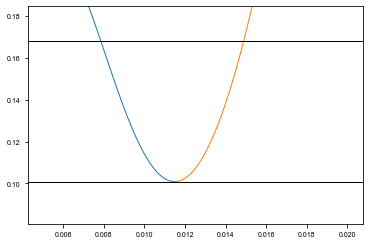

In [25]:
x = V_peaks
y = np.log(currents)

# Get baseline fit
popt, pcov = curve_fit(Butler_Volmer_log, x, y, bounds=([0., 0., 1.],
                                                        [1, 1., 3.]))

print(popt[0])

n = len(x)
p = len(popt)
    
# Calculate SSR
y_pred = Butler_Volmer_log(x, *popt)
SSR = np.sum((y - y_pred) ** 2)

# Calculate SSR threshold. 95% CI
SSR_threshold = SSR * (1 + scipy.stats.f.isf(0.05, 1, n - p) / (n - p) )

# Preinitialize
n_points = 100
i0_left = np.linspace(5e-3, popt[0], n_points)
i0_right = np.linspace(popt[0], 2e-2, n_points)
SSR_left = np.zeros((n_points, 1))
SSR_right = np.zeros((n_points, 1))

f_mod = lambda x, alpha, E0: Butler_Volmer_log(x, i0, alpha, E0)

# Go through left side of parameter
for k, i0 in enumerate(i0_left):
        
    popt_left, _ = curve_fit(f_mod, x, y, maxfev=1e5, bounds=([0.01, 1.],
                                                  [0.99, 1.2]))
    y_pred = f_mod(x, *popt_left)
    SSR_left[k] = np.sum((y - y_pred) ** 2)
        
# Go through right side of exponent
for k, i0 in enumerate(i0_right):        
    popt_right, _ = curve_fit(f_mod, x, y, maxfev=1e5, bounds=([0.01, 1.],
                                                  [0.99, 1.2]))
    y_pred = f_mod(x, *popt_right)
    SSR_right[k] = np.sum((y - y_pred) ** 2)


# Find the intersection points
try:
    exp_lower_CI = i0_left[ np.where(SSR_left  < SSR_threshold)[0][0]]
    exp_upper_CI = i0_right[np.where(SSR_right > SSR_threshold)[0][0]]
    exp_CIs = np.array([exp_lower_CI, exp_upper_CI])
except IndexError: # CIs are very large; set as undefined
    exp_CIs = [np.nan, np.nan]

# Plot
plt.plot(i0_left, SSR_left)
plt.plot(i0_right, SSR_right)
plt.axhline(SSR, color='k')
plt.axhline(SSR_threshold, color='k')
plt.ylim([0.8*SSR, 1.1*SSR_threshold])
    
exp_CIs, 1/exp_CIs

## 95% CIs: Alpha

0.1951129276743987


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


[0.18396905171246833, 0.20642523327694473]

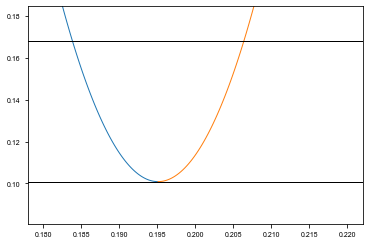

In [26]:
x = V_peaks
y = np.log(currents)

# Get baseline fit
popt, pcov = curve_fit(Butler_Volmer_log, x, y, bounds=([0., 0., 1.],
                                                        [1, 1., 3.]))

print(popt[1])
    
n = len(x)
p = len(popt)
    
# Calculate SSR
y_pred = Butler_Volmer_log(x, *popt)
SSR = np.sum((y - y_pred) ** 2)

# Calculate SSR threshold. 95% CI
SSR_threshold = SSR * (1 + scipy.stats.f.isf(0.05, 1, n - p) / (n - p) )

# Preinitialize
n_points = 100
alpha_left = np.linspace(0.18, popt[1], n_points)
alpha_right = np.linspace(popt[1], 0.22, n_points)
SSR_left = np.zeros((n_points, 1))
SSR_right = np.zeros((n_points, 1))
    
f_mod = lambda x, i0, E0: Butler_Volmer_log(x, i0, alpha, E0)
    
# Go through left side of parameter
for k, alpha in enumerate(alpha_left):
        
    popt_left, _ = curve_fit(f_mod, x, y, maxfev=1e5, bounds=([0, 1.],
                                                  [0.1, 2.]))
    y_pred = f_mod(x, *popt_left)
    SSR_left[k] = np.sum((y - y_pred) ** 2)
        
# Go through right side of exponent
for k, alpha in enumerate(alpha_right):        
    popt_right, _ = curve_fit(f_mod, x, y, maxfev=1e5, bounds=([0, 1.],
                                                  [0.1, 2.]))
    y_pred = f_mod(x, *popt_right)
    SSR_right[k] = np.sum((y - y_pred) ** 2)

    
# Find the intersection points
try:
    exp_lower_CI = alpha_left[ np.where(SSR_left  < SSR_threshold)[0][0]]
    exp_upper_CI = alpha_right[np.where(SSR_right > SSR_threshold)[0][0]]
    exp_CIs = [exp_lower_CI, exp_upper_CI]
except IndexError: # CIs are very large; set as undefined
    exp_CIs = [np.nan, np.nan]

# Plot
plt.plot(alpha_left, SSR_left)
plt.plot(alpha_right, SSR_right)
plt.axhline(SSR, color='k')
plt.axhline(SSR_threshold, color='k')
plt.ylim([0.8*SSR, 1.1*SSR_threshold])
    
exp_CIs

## 95% CIs: E_0

1.0550387532781795


array([1.04966447, 1.06957168])

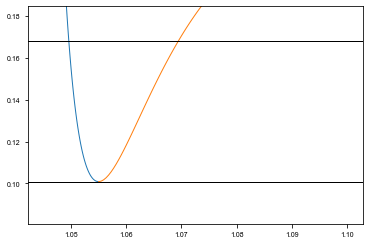

In [27]:
x = V_peaks
y = np.log(currents)

# Get baseline fit
popt, pcov = curve_fit(Butler_Volmer_log, x, y, bounds=([0., 0., 1.],
                                                        [1, 1., 3.]))

print(popt[2])

n = len(x)
p = len(popt)

# Calculate SSR
y_pred = Butler_Volmer_log(x, *popt)
SSR = np.sum((y - y_pred) ** 2)

# Calculate SSR threshold. 95% CI
SSR_threshold = SSR * (1 + scipy.stats.f.isf(0.05, 1, n - p) / (n - p) )

# Preinitialize
n_points = 100
E0_left = np.linspace(1.045, popt[2], n_points)
E0_right = np.linspace(popt[2], 1.1, n_points)
SSR_left = np.zeros((n_points, 1))
SSR_right = np.zeros((n_points, 1))
    
f_mod = lambda x, i0, alpha: Butler_Volmer_log(x, i0, alpha, E0)


# Go through left side of parameter
for k, E0 in enumerate(E0_left):
        
    popt_left, _ = curve_fit(f_mod, x, y, maxfev=1e5, bounds=([0, 0.01],
                                                  [0.1, 0.99]))
    y_pred = f_mod(x, *popt_left)
    SSR_left[k] = np.sum((y - y_pred) ** 2)
        
# Go through right side of exponent
for k, E0 in enumerate(E0_right):        
    popt_right, _ = curve_fit(f_mod, x, y, maxfev=1e5, bounds=([0, 0.01],
                                                  [0.1, 0.99]))
    y_pred = f_mod(x, *popt_right)
    SSR_right[k] = np.sum((y - y_pred) ** 2)

    
# Find the intersection points
try:
    exp_lower_CI = E0_left[ np.where(SSR_left  < SSR_threshold)[0][0]]
    exp_upper_CI = E0_right[np.where(SSR_right > SSR_threshold)[0][0]]
    exp_CIs = np.array([exp_lower_CI, exp_upper_CI])
except IndexError: # CIs are very large; set as undefined
    exp_CIs = [np.nan, np.nan]

# Plot
plt.plot(E0_left, SSR_left)
plt.plot(E0_right, SSR_right)
plt.axhline(SSR, color='k')
plt.axhline(SSR_threshold, color='k')
plt.ylim([0.8*SSR, 1.1*SSR_threshold])
    
exp_CIs

This is a good example of an asymptotic confidence interval